In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
# import pandas_profiling 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set(style="whitegrid")
%matplotlib inline
from scipy.stats import zscore
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import requests
from io import StringIO

#setting up for customized printing
from IPython.display import Markdown, display
from IPython.display import HTML
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
#function to display dataframes side by side    
from IPython.display import display_html
def display_side_by_side(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline;margin-left:50px !important;margin-right: 40px !important"'),raw=True)

In [4]:
df = pd.read_csv('../data/ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'Rating','timestamp'])

In [5]:
df.drop('timestamp', axis=1, inplace=True)

In [6]:
df.head()

,userId,movieId,Rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [7]:
print('Số lượng user: ' + str(df.userId.nunique()))
print('Số lượng item: ' + str(df.movieId.nunique()))
print('Số lượng rating: ' + str(sorted(df.Rating.unique().tolist())))

Số lượng user: 943
Số lượng item: 1682
Số lượng rating: [1, 2, 3, 4, 5]


In [8]:
# movies_groupby_users_Ratings = df.groupby('userId')['Rating']
# movies_groupby_users_Ratings = pd.DataFrame(movies_groupby_users_Ratings.count())
# user_list_min50_ratings = movies_groupby_users_Ratings[movies_groupby_users_Ratings['Rating'] >= 50].index
# df =  df[df['userId'].isin(user_list_min50_ratings)]
df

,userId,movieId,Rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   userId   100000 non-null  int64
 1   movieId  100000 non-null  int64
 2   Rating   100000 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


In [10]:
display(df[['Rating']].describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Rating,100000.0,3.52986,1.125674,1.0,3.0,4.0,4.0,5.0


## Observations
__Rating__ : This is can be considered as categorical attribute with values of (1,2,3,4,5). The mean rating is 3.52 which means most of the users have given good ratings for the movies i.e. many records with ratings above 3. This can be seen from the median (Q2), 75% (Q3) values as 4 and max values as 5. Even 25% (Q1) value is 3.0.

In [11]:
pal = sns.color_palette(palette='Set1', n_colors=16)

In [12]:
def distplot(figRows,figCols,xSize, ySize, data, features, colors, kde=True, bins=None):
    f, axes = plt.subplots(figRows, figCols, figsize=(xSize, ySize))
    
    features = np.array(features).reshape(figRows, figCols)
    colors = np.array(colors).reshape(figRows, figCols)
    
    for row in range(figRows):
        for col in range(figCols):
            if (figRows == 1 and figCols == 1) :
                axesplt = axes
            elif (figRows == 1 and figCols > 1) :
                axesplt = axes[col]
            elif (figRows > 1 and figCols == 1) :
                axesplt = axes[row]
            else:
                axesplt = axes[row][col]
            plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})
            plot.set_xlabel(features[row][col],fontsize=20)

In [13]:
def scatterplot(rowFeature, colFeature, data):
    f, axes = plt.subplots(1, 1, figsize=(10, 8))
        
    plot=sns.scatterplot(x=rowFeature, y=colFeature, data=data, ax=axes)
    plot.set_xlabel(rowFeature,fontsize=20)
    plot.set_ylabel(colFeature,fontsize=20) 

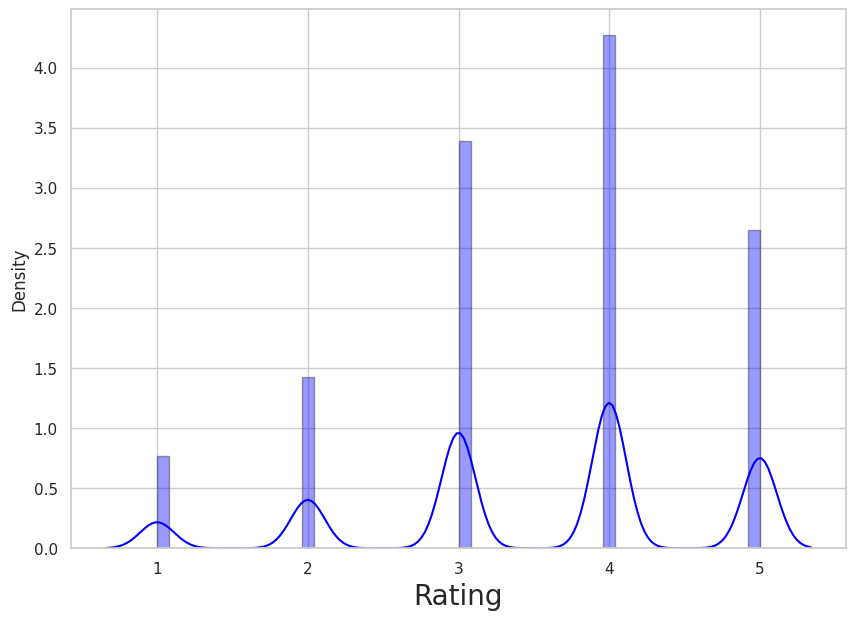

In [14]:
distplot(1, 1, 10, 7, data=df, features=['Rating'], colors=['blue'])

## Observations
Many users have rated 4 as it is shown with the huge spike
This is followed by rating 3 which also has high number
Ratings 1, 2, 5 are comparatively less.

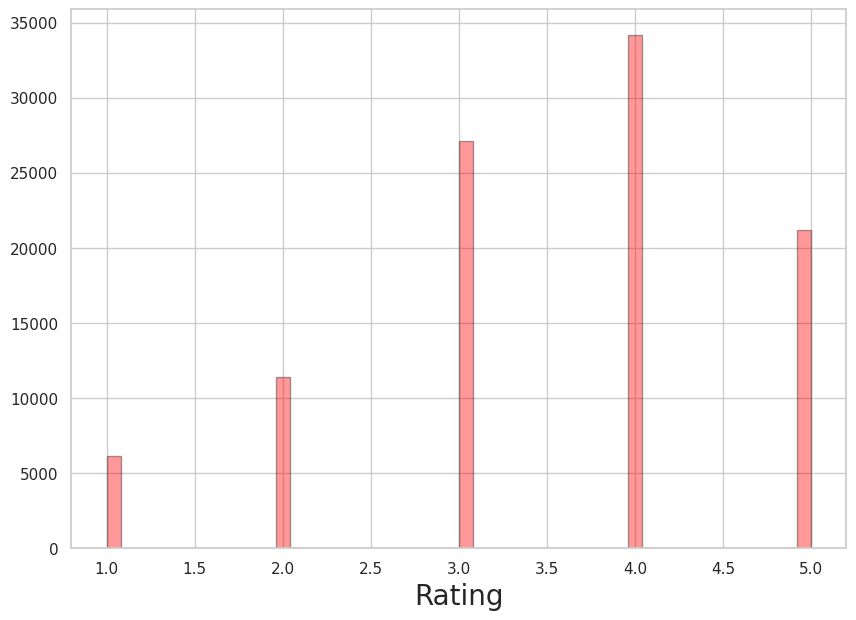

In [15]:
distplot(1, 1, 10, 7, data=df, features=['Rating'], colors=['red'], kde=False)

## Observations
Many users have rated 4 as it is shown with the huge spike with a value of more than 30k records.<br>
This is followed by rating 3 which also has high number with a value of mroe than 20k records.<br>
More than 15k users have rated 5.<br>
Rating 1 and 2 have been rated under 15k records.

,Rating_Count
movieId,
1,30
2,30
3,30
4,30
5,30
...,...
1678,1
1679,1
1680,1


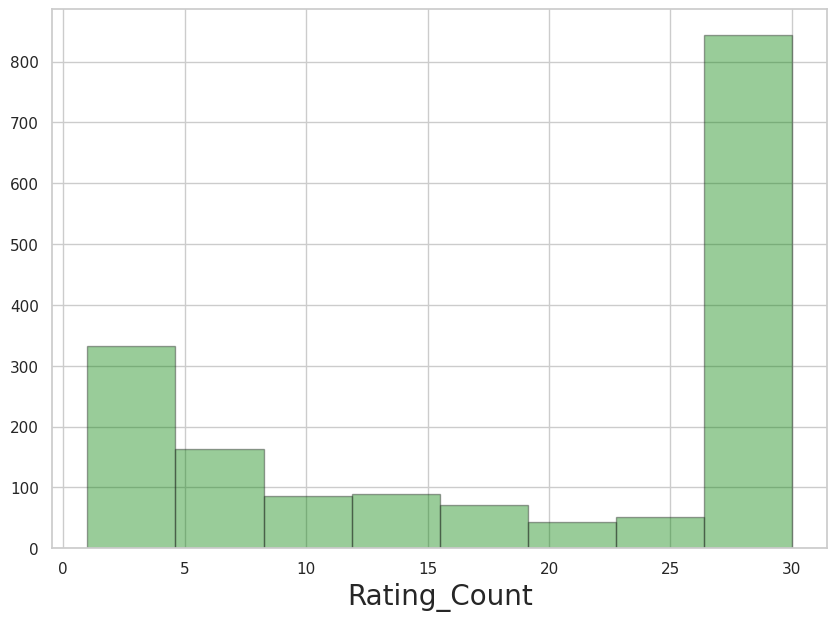

In [16]:
movies_groupby_movie_Ratings = df.groupby('movieId')['Rating']
# display(movies_groupby_movie_Ratings.count())
# display(movies_groupby_movie_Ratings.count().clip(upper=30).unique())
ratings_movies = pd.DataFrame(movies_groupby_movie_Ratings.count().clip(upper=30))
ratings_movies.rename(columns={"Rating": "Rating_Count"}, inplace=True)
display(ratings_movies)
distplot(1, 1, 10, 7, data=ratings_movies, features=['Rating_Count'], colors=['green'], kde=False)

## Observations
This is a ratings count distribution grouped by all the Movies. For the plot perspective, I have clipped the upper limit to 30 which means any value above 30 will be set to it.

As it can been seen from the plot, there are many products which were rated only once i.e. only one user have rated. And then the count decreases and after that it increases.

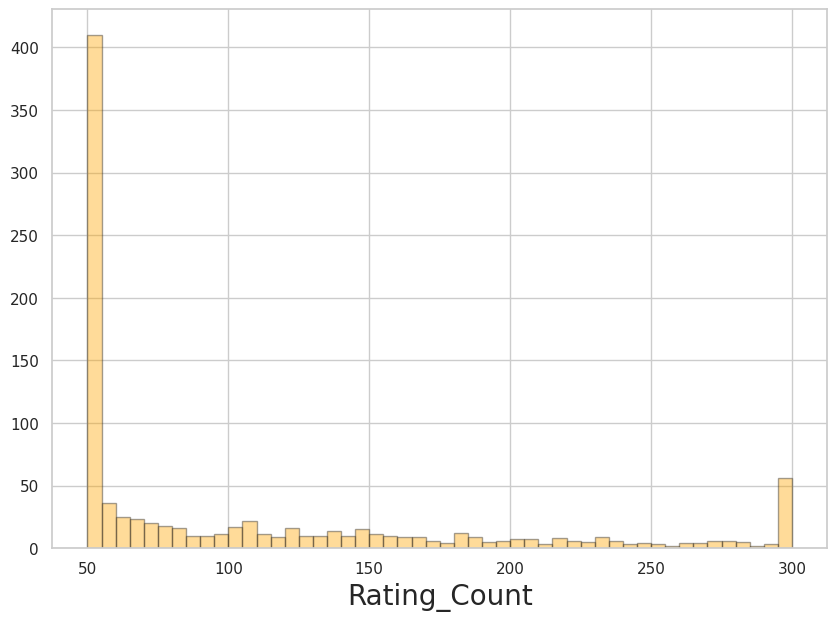

In [17]:
movies_groupby_users_Ratings = df.groupby('userId')['Rating']
movies_groupby_users_Ratings.count().clip(lower=50).unique()
rating_users = pd.DataFrame(movies_groupby_users_Ratings.count().clip(lower=50, upper=300))
rating_users.rename(columns={"Rating": "Rating_Count"}, inplace=True)
distplot(1, 1, 10, 7, data=rating_users, features=['Rating_Count'], colors=['orange'], kde=False, bins=50)

## Observations

This is a ratings count distribution grouped by all the Users. For the plot perspective, I have clipped the count limit between 50 to 300 which means any value below 50 or above 300 will be set to the respective values.

As it can been seen from the plot, there are many users which have rated 50 times or below. Ratings count by users gradually decreases which means few users have rated many products.

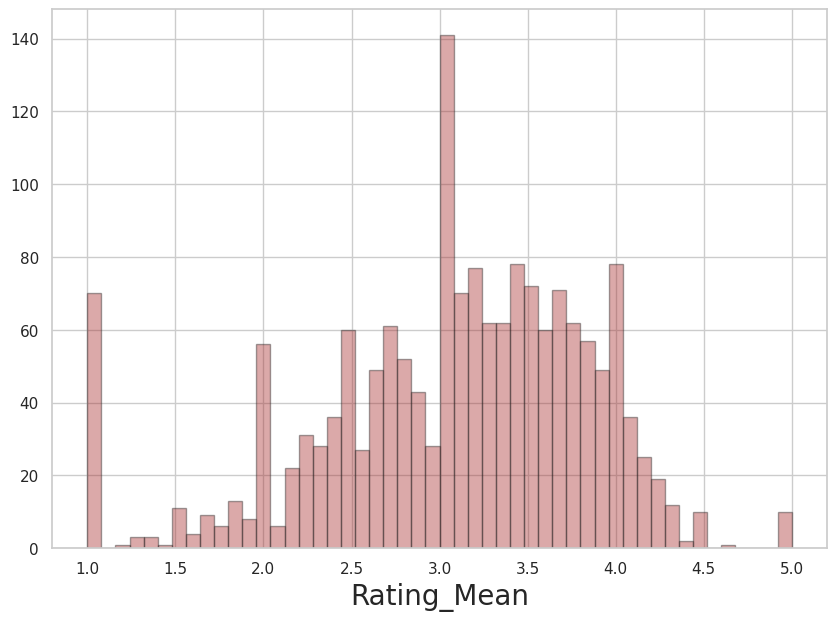

In [18]:
ratings = pd.DataFrame(df.groupby('movieId')['Rating'].mean())
ratings.rename(columns={"Rating": "Rating_Mean"}, inplace=True)
distplot(1, 1, 10, 7, data=ratings, features=['Rating_Mean'], colors=['brown'], kde=False, bins=50)

## Observations

This is a mean rating distribution grouped by all the Movies.

As it can been seen from the plot, there are many products which were given a Rating of 3 or 4. Hence the plot shows lot of bins between 3 and 4.

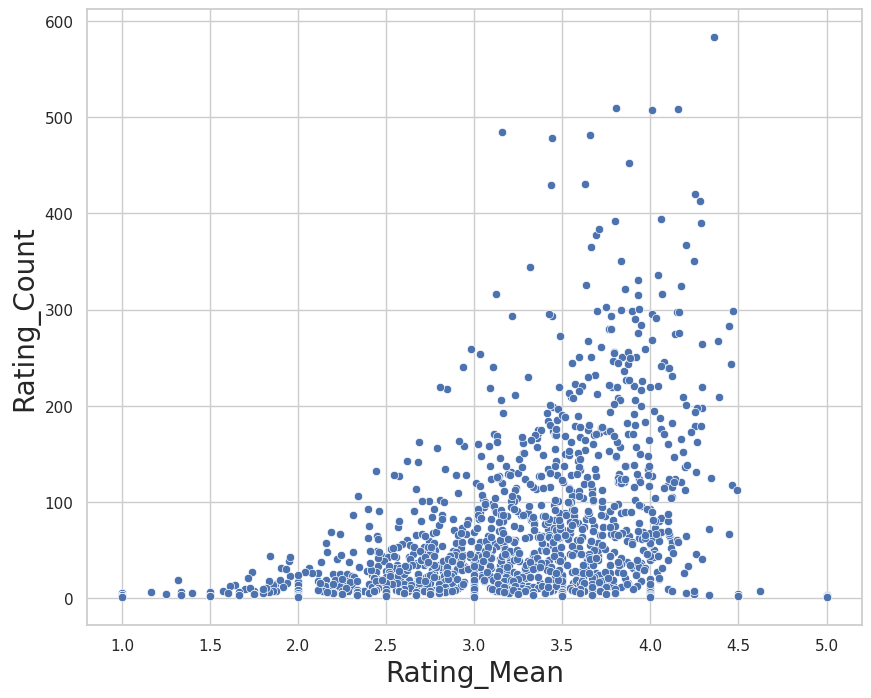

In [19]:
ratings['Rating_Count'] = df.groupby('movieId')['Rating'].count()
scatterplot('Rating_Mean', 'Rating_Count', data=ratings)

## Observations

This is a joint plot between Mean rating distribution and Rating Count grouped by all the Movies. As shown in the plot, data is clustered between mean rating of 2.5 to 4.

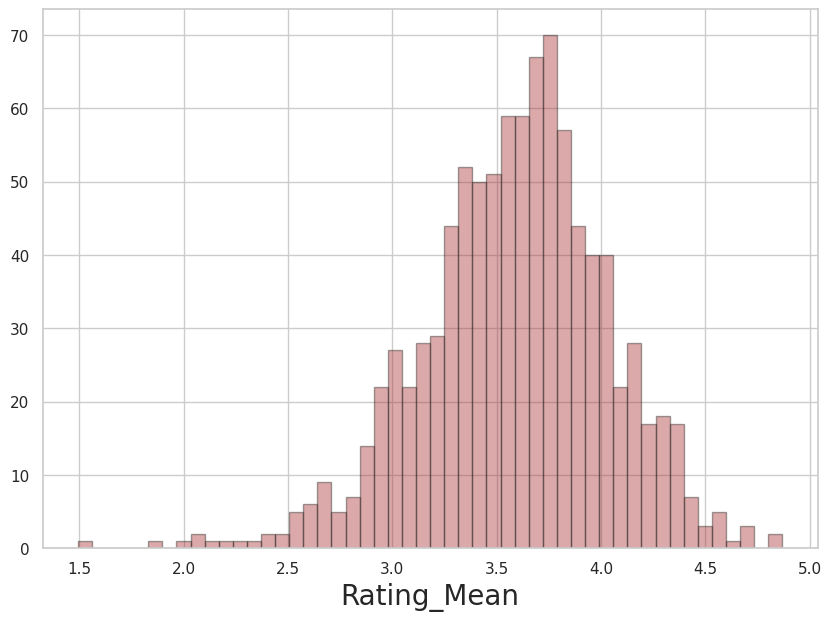

In [20]:
ratings = pd.DataFrame(df.groupby('userId')['Rating'].mean())
ratings.rename(columns={"Rating": "Rating_Mean"}, inplace=True)
distplot(1, 1, 10, 7, data=ratings, features=['Rating_Mean'], colors=['brown'], kde=False, bins=50)

## Observations

This is a mean rating distribution grouped by all the Users. This looks like slightly left skewed normal distribution.

Data is uniformly distribution from rating 3 to 5 with many around 4 to 4.5. Many users have an average rating of around 4.5.

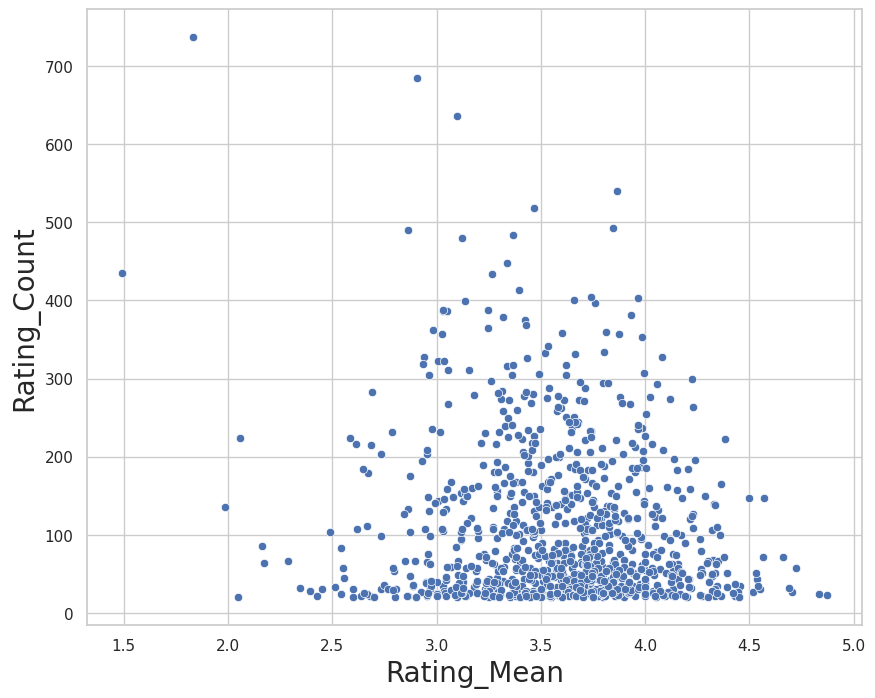

In [21]:
ratings['Rating_Count'] = df.groupby('userId')['Rating'].count()
scatterplot('Rating_Mean', 'Rating_Count', data=ratings)

## Observations

This is a joint plot between Mean rating distribution and Rating Count grouped by all the Users. As shown in the plot, data is clustered between 3 to 4.5. There are many data points when the Rating count is less than 100 and the mean rating for the users is between 3.5 and 4

---

# __Collaborative Filtering__
Recommender System sử dụng kỹ thuật Collaborative Filtering (lọc cộng tác) để đưa ra gợi ý cho một nguòi dùng một "item" dựa trên các người dùng tương đồng khác _(similar user)_ một cách tự động. <br>
Bài toán tập trung cố gắng dự đoán rating mà người dùng sẽ đánh giá cho các sản phẩm mà họ chưa tương tác, và gợi ý sản phẩm đó cho họ nếu điểm rating dự đoán đủ cao.

## __Các bước tiếp cận thuật toán__:
+ Tìm `similarity` cho một __target user__ hoặc một __target item__.
+ Dự đoán __rating__ mà __target user__ sẽ đánh giá cho các __items__. Để lọc ra các __items__ có mức rating cao và giới thiệu nó cho user.
+ Đo lường độ chính xác của hệ thống.

## __User-based Collaborative Filtering__

<p align="center">
    <img src="https://machinelearningcoban.com/assets/24_collaborativefiltering/user_cf.png" width="1200">
</p>

## __Tính toán similarity__

+ Tính toán `similarity` nhằm tìm ra các người dùng tương đương (similar user) cho bước dự đoán rating.

+ Việc tính toán `similarity` sẽ không phụ thuộc vào bất cứ vào thông tin của user hoặc item. Ví dụ như tuổi của user, thể loại phim,... Kỹ thuật chỉ tập trung vào việc tính toán dựa trên mức rating mà các người dùng đánh giá cho sản phẩm.<br>

__Giả sử__ hai users được cho là tương đồng (similar) nếu họ đánh giá giống nhau về 10 bộ phim mặc dù họ có cách biệt khác nhau về tuổi tác.

## __Bài toán ví dụ.__

Để tính giá trị rating __`R`__ mà một user __`U`__ dành cho một item __`I`__, cách tiếp cận sẽ là:
+ Tìm kiếm các similar users với người dùng __`U`__ đã từng đánh giá item __`I`__.
+ Tính rating __`R`__ dựa trên tất cả các similar users tìm được ở bước trên

,movie 1,movie 2
A,1.0,2.0
B,2.0,4.0
C,2.5,4.0
D,4.5,5.0


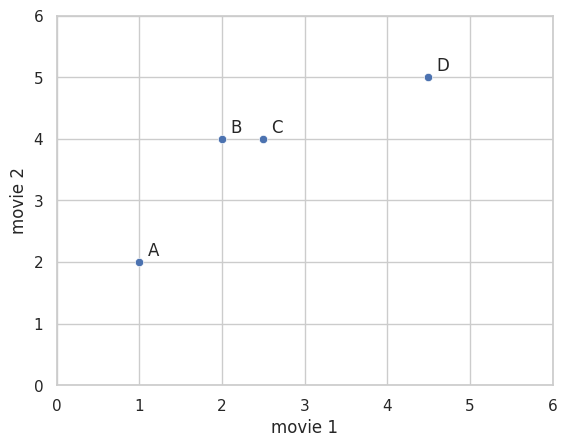

In [22]:
exdf = pd.DataFrame({'movie 1': [1.0, 2.0, 2.5, 4.5], 'movie 2': [2.0, 4.0, 4.0, 5.0]}, columns=['movie 1', 'movie 2'], index = ['A', 'B', 'C', 'D'])
display(exdf)
sns.scatterplot(x='movie 1', y='movie 2', data=exdf)
for idx, row in exdf.iterrows(): 
    plt.text(row['movie 1'] + 0.1, row['movie 2']+ 0.1, idx)
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.show()

Để xác định các similar user, đối với các điểm được biểu diễn cụ thể trên mặt phẳng 2D trên, phép tính Euclidean sẽ đánh giá chính xác khoảng cách giữa 2 điểm bất kì. Từ đó có thể xác định được khoảng cách giữa các điểm. 
+ Nếu khoảng cách giữa hai điểm càng lớn, similarity càng nhỏ và ngược lại.

In [23]:
from scipy import spatial

a = [1, 2]
b = [2, 4]
c = [2.5, 4]
d = [4.5, 5]

print('The Euclidean between C and A:', spatial.distance.euclidean(c, a))

print('The Euclidean between C and B:', spatial.distance.euclidean(c, b))

print('The Euclidean between C and D:', spatial.distance.euclidean(c, d))


The Euclidean between C and A: 2.5
The Euclidean between C and B: 0.5
The Euclidean between C and D: 2.23606797749979


Có thể thấy điểm `B` sẽ cận điểm `C` do khoảng cách Euclidean là nhỏ nhất so với `A` và `D`. Tuy nhiên giả sử chỉ có và `A` và `D` thì ai sẽ là điểm tương đồng với `C`? 

Nếu dựa vào kết quả do độ đo Euclidean, có thể thấy, `C` và `D` có mức tương tự cao hơn so với `A`. Tuy nhiên nếu dựa vào mức rating để đánh giá về sự tương đồng giữa hai người dùng:
+ Số điểm rating của `C` gần như gấp đôi so với `A`, và `C` cũng giống `A`, cả hai thích item thứ 2 gấp 2 lần so với item thứ 1. Còn `D` thì thích cả hai item.

Điều này dẫn đến, khoảng cách Euclidean trong trường hợp này không đo được sự tương tự giữa `A` và `C` dựa trên đặc trưng rating của người dùng. 

Về cơ bản, Euclidean là chỉ thể hiện khoảng cách về mặt vật lí giữa hai điểm nằm trên không gian, tuy nhiên ở khoảng đo sự tương đồng giữa hai người dùng, thì khoảng cách vật lí này sẽ không phát huy được hiểu quả tốt nhất, giả sử cho tình huống bên trên. Euclidean chỉ quan tâm đến khoảng cách giữa 2 điểm, mà chưa thể hiện rõ không gian đặc trưng (features) giữa các người dùng.

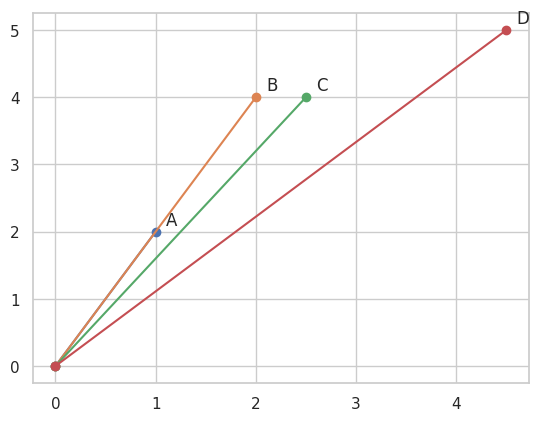

In [24]:
o1, a = [0, 1], [0, 2]
o2, b = [0, 2], [0, 4]
o3, c = [0, 2.5], [0, 4]
o4, d = [0, 4.5], [0, 5]

plt.plot(o1, a, o2, b, o3, c, o4, d, marker = 'o')

for idx, row in exdf.iterrows(): 
    plt.text(row['movie 1'] + 0.1, row['movie 2']+ 0.1, idx)
plt.show()

Một cách tiếp cận khác, đó là sử dụng tích vô hướng (độ đo cosine) giữa 2 điểm đổi với gốc tọa độ (0, 0). Nếu tiếp cận theo cách này, không gian đặc trưng sẽ được thể hiện rõ ràng hơn, những người dùng có những đánh giá gần giống nhau, thì góc cosine được tạo bởi các người dùng và góc tọa độ sẽ càng nhỏ nhỏ (như hình minh họa trên).

Giá trị Cosine_Similarity (liên quan đến góc cosine trong tích vô hướng) sẽ giao động trong khoảng (-1, 1) tương ứng với góc (0, 180) độ. Giá trị cosine_similarity càng cao thì độ tương thích càng lớn.

Giá trị Cosine_Distance cho biết khoảng cách giữa 2 vector theo góc cosine giữa chúng. Vì thế nên Cosine_Distance luôn dương và giá trị trải dài từ [0, 2]
Vì thế giá trị `cosine_similarity` = 1 - `cosine_distance`

In [25]:
from scipy import spatial # Thư viện khai báo tính toán cosine distance
a = [1, 2]
b = [2, 4]
c = [2.5, 4]
d = [4.5, 5]

print("Cosine C and A:", 1- spatial.distance.cosine(c,a))
print("Cosine C and B:", 1- spatial.distance.cosine(c,b))
print("Cosine C and D:", 1- spatial.distance.cosine(c,d))
print("Cosine A and B:", 1- spatial.distance.cosine(a,b))

Cosine C and A: 0.9954954725939521
Cosine C and B: 0.9954954725939521
Cosine C and D: 0.984862774053917
Cosine A and B: 1


## __Chuẩn hóa dữ liệu rating__

### __1. Lý do chuẩn hóa__

Theo độ đo cosine, hai người dùng `A` và `B` có thể được gọi là hai người dùng tương tự tuyệt đối (vì similarity = 0 theo cosine) mặc dù rating họ dành cho item khác nhau. Trong thế giới thực, các trường hợp như người dùng `A` được gọi là `tough raters` (người dùng khó tính). Những người như người dùng `A` sẽ luôn đánh giá một item dưới mức trung bình (mức trung bình được tính theo tất cả các đánh giá của những người dùng khác cho sản phẩm), nhưng mà những item mà họ đánh giá thì lại giống với danh sách item do `easy raters` như là `B`.<br>
+ Giả sử như ng dùng `A` đánh giá tất cả sản phẩm là __1__ và `B` đánh giá tất cả sản phẩm là __5__.

Vì đánh giá của mỗi người dùng đều mang tính cá nhân, nhưng sự tương đồng về việc yêu thích hay không thích một item được thể hiện trên số điểm rating của họ, và được làm rõ trên không gian đặc trưng thông qua các độ đo, nên cần phải chuẩn hóa các rating theo khuynh hướng cá nhân này về một mức chung, loại bỏ các thành kiến cá nhân.

Mục tiêu của kỹ thuật Collaborative Filtering là đưa ra dự đoán rating của 1 người dùng bất kì đối với một sản phẩm mà họ chưa được tương tác. Bởi vì mỗi một giá trị rating của người dùng đối với từng sản phẩm đều thể hiện sự yêu thích của người dùng đó với sản phẩm, bên cạnh đó, rating cũng đánh giá sự tương tác của người dùng với sản phẩm đó. Nếu để trống thì tức là sản phẩm đó chưa được họ tương tác. Điều đó cũng ảnh hưởng đến vị trí của của người dùng trên đồ thị. Trước khi thực hiện đo similarity giữa các người dùng, cần phải thực hiện "fill in" các dữ liệu đang rỗng bằng một giá trị nào đó đánh giá rằng họ vẫn chưa có tương tác với sản phẩm.

### __2. Hướng tiếp cận__
#### __2.1 Fill in các giá trị trống__

##### _Giả sử nếu điền các ô trống là giá trị 0, thì sẽ thế nào?_ <br>

Nếu giá trị điền vào ô trống là 0, thì dẫn đến mức __rating trung bình__ của mỗi người dùng vẫn không tụ lại 1 giá trị, như vậy các người dùng vẫn còn độc lập, vẫn chưa thể bỏ qua các ý kiến cá nhân trong mỗi người dùng. 

##### _Giả sử nếu điền vào ô trống các giá trị rating trung bình của mỗi người dùng?_ <br>

__Rating trung bình__ của `A` là 1.5, `B` là 3, `C` là 3.25 `D` là 4.75.

Việc fill-in bằng các giá trị trung bình sẽ ảnh hưởng:

+ __Thay đổi magnitude__: Khi fill-in bằng giá trị trung bình, các mục chưa được đánh giá sẽ được thay thế bằng giá trị trung bình của tất cả các mục. Điều này có thể làm thay đổi magnitude của các vector, đặc biệt là các vector mà có ít mục đã được đánh giá. Kết quả là các người dùng có thể có magnitude khác nhau sau khi fill-in, dẫn đến sự khác biệt trong độ tương tự giữa chúng.

+ __Thay đổi phản ứng đối với các mục chưa được đánh giá__: Fill-in bằng giá trị trung bình có thể làm thay đổi cách mà hệ thống phản ứng đối với các mục chưa được đánh giá. Cụ thể, nếu một người dùng đã đánh giá nhiều mục và một người dùng khác chỉ đánh giá ít mục, thì fill-in bằng giá trị trung bình có thể làm cho các mục chưa được đánh giá ảnh hưởng nhiều hơn đối với người dùng đánh giá ít mục.

+ __Ảnh hưởng của outliers__: Nếu có outliers trong dữ liệu (các giá trị đánh giá rất cao hoặc rất thấp), fill-in bằng giá trị trung bình có thể bị ảnh hưởng bởi những giá trị này, dẫn đến sự biến đổi không mong muốn trong độ tương tự giữa các người dùng.

##### _Sử dụng kĩ thuật Centered Vector_

+ __Loại bỏ các yếu tố cá nhân__: Centered Vector là một phương pháp trong xử lý dữ liệu và phân tích dữ liệu. Sử dụng phương pháp Centered Vector đưa các giá trị trung bình của từng điểm dữ liệu về lại 0, giúp loại bỏ đi các yếu tố cá nhân của người dùng.

+ __Tăng khả năng phân tích__: Phương pháp này giúp điều chỉnh giá trị trung bình của toàn bộ điểm dữ liệu về gần giá trị 0. Để tạo ra một Centered Vector cho từng điểm dữ liệu, ta lấy giá trị từng phần tử của vector trừ đi giá trị trung bình của vector đó. Các user lúc này sẽ có mức trung bình rating gần với giá trị 0, dẫn đến các dữ liệu được chuẩn hóa cho cùng phân phối, bỏ qua các yếu tố cá nhân, dẫn đến dễ dàng tìm ra các similar user/item dễ dàng hơn, hiệu quả hơn, tập trung vào sự khác biệt giữa các user (biến thiên), tăng khả năng phân tích hiệu quả hơn.

## __Bài toán ví dụ__

In [26]:
# Tạo ra ma trận item-user với:
    # mỗi hàng là rating của một item được cho bởi tất cả users.
    # mỗi cột là rating của một user dành cho tất cả items.

    # giá trị "nan" tương ứng với giá item chưa được user tương tác.
matrix = np.array([[5,5,2,0,1,np.nan, np.nan],
                   [4,np.nan, np.nan,0,np.nan,2,np.nan],
                   [np.nan,4,1,np.nan,np.nan,1,1],
                   [2,2,3,4,4,np.nan,4],
                   [2,0,4,np.nan,np.nan,np.nan,5]
                   ])
n_items, n_users = matrix.shape
print('Number Items:', n_items)
print('Number Users:', n_users)
display(matrix)

Number Items: 5
Number Users: 7


array([[ 5.,  5.,  2.,  0.,  1., nan, nan],
       [ 4., nan, nan,  0., nan,  2., nan],
       [nan,  4.,  1., nan, nan,  1.,  1.],
       [ 2.,  2.,  3.,  4.,  4., nan,  4.],
       [ 2.,  0.,  4., nan, nan, nan,  5.]])

### __Chuẩn hóa dữ liệu__
+ Bước 1: Tính toán giá trị trung bình rating của từng user đối với tất cả items.


In [27]:
mean_user_rating = np.nanmean(matrix, axis=0)
print(mean_user_rating)

[3.25       2.75       2.5        1.33333333 2.5        1.5
 3.33333333]


+ Bước 2: Trừ tất cả giá trị rating cho giá trị trung bình.

In [28]:
normalized_matrix = matrix - mean_user_rating
print(normalized_matrix)

[[ 1.75        2.25       -0.5        -1.33333333 -1.5                nan
          nan]
 [ 0.75               nan         nan -1.33333333         nan  0.5
          nan]
 [        nan  1.25       -1.5                nan         nan -0.5
  -2.33333333]
 [-1.25       -0.75        0.5         2.66666667  1.5                nan
   0.66666667]
 [-1.25       -2.75        1.5                nan         nan         nan
   1.66666667]]


+ Bước 3: Fill in tất cả missing value = giá trị 0.

In [29]:
normalized_matrix = np.nan_to_num(normalized_matrix)
print(normalized_matrix)

[[ 1.75        2.25       -0.5        -1.33333333 -1.5         0.
   0.        ]
 [ 0.75        0.          0.         -1.33333333  0.          0.5
   0.        ]
 [ 0.          1.25       -1.5         0.          0.         -0.5
  -2.33333333]
 [-1.25       -0.75        0.5         2.66666667  1.5         0.
   0.66666667]
 [-1.25       -2.75        1.5         0.          0.          0.
   1.66666667]]


### __Tính Cosine Similarity__

In [30]:
ones_matrix = np.ones((n_users, n_users))

In [31]:
a = normalized_matrix[:, 0]
b = normalized_matrix[:, 1]
print(a)
print(b)

[ 1.75  0.75  0.   -1.25 -1.25]
[ 2.25  0.    1.25 -0.75 -2.75]


In [32]:
dot_product = np.dot(a, b)
norm_vector1 = np.linalg.norm(a)
norm_vector2 = np.linalg.norm(b)
cosine_similarity = dot_product / (norm_vector1 * norm_vector2)
print("Cosine Similarity:", cosine_similarity)

Cosine Similarity: 0.8330743477031354


In [33]:
from sklearn.metrics.pairwise import cosine_similarity
vec1 = a.reshape(1, -1)
vec2 = b.reshape(1, -1)
cosine_similarity_score = cosine_similarity(vec1, vec2)
print("Cosine Similarity:", cosine_similarity_score)


Cosine Similarity: [[0.83307435]]


In [34]:
for user in range(n_users):
    for other_user in range(n_users):
        if user != other_user:
            a = normalized_matrix[:, user]
            b = normalized_matrix[:, other_user]
            ones_matrix[user, other_user] = 1 - spatial.distance.cosine(a,b)
similarity_matrix = ones_matrix.copy()

In [35]:
similarity_matrix

array([[ 1.        ,  0.83307435, -0.5809475 , -0.7856742 , -0.81649658,
         0.20412415, -0.38133693],
       [ 0.83307435,  1.        , -0.87333376, -0.3986205 , -0.55234477,
        -0.23014365, -0.70756759],
       [-0.5809475 , -0.87333376,  1.        ,  0.27386128,  0.31622777,
         0.47434165,  0.9621024 ],
       [-0.7856742 , -0.3986205 ,  0.27386128,  1.        ,  0.8660254 ,
        -0.28867513,  0.18490007],
       [-0.81649658, -0.55234477,  0.31622777,  0.8660254 ,  1.        ,
         0.        ,  0.16012815],
       [ 0.20412415, -0.23014365,  0.47434165, -0.28867513,  0.        ,
         1.        ,  0.56044854],
       [-0.38133693, -0.70756759,  0.9621024 ,  0.18490007,  0.16012815,
         0.56044854,  1.        ]])

### __Tính Rating Prediction__

Một công thức phổ biến cho việc dự đoán rating:

$$
    \hat{y}_{i, u} = \frac{\sum{u_j\in\N(u,i)}\bar{y}_{i,u_i} \cdot sim(u,u_j)}{\sum{u_j\in\N(u,i)} \cdot |sim(u,u_j)|}
$$

với:<br>
$\bar{y}$: là ma trận chuẩn hóa<br>
$sim(u, u_j)$: là hàm tính simularity của target user `u` và một similar user

Ý nghĩa công thức: <br>
1. Ta tính toán similarity giữa target user `u` và mỗi người dùng khác $u_j$ trong tập hợp các người dùng đã đánh giá mục `i`. Similarity được đo lường bằng cosine similarity.<br>

2. Tính tổng của tích của similarity ($sim(u, u_j)$) và rating ($\bar{y}_{i, u_i}$) của các similar user đã đánh giá cho mục đó `i`. Điều này nhấn mạnh rằng chúng ta đang quan tâm đến những người dùng có hành vi đánh giá gần giống với target user.

3. Chia tổng này cho tổng của các similarity. Điều này là để chuẩn hóa và đảm bảo rằng rating dự đoán là một trung bình có trọng số của các rating của những similar user.

In [36]:
def find_similar_users(user_id, similarity_matrix, k):
    similar_user = similarity_matrix[user_id]
    # sort increasing the user based on similarity by using argsort and then reverse it [::-1]
    similar_users = np.argsort(similar_user)[::-1][1:k+1]
    return similar_users

In [37]:
find_similar_users(1, similarity_matrix, 2)

array([0, 5])

In [38]:
def rating_predict(user) -> np.ndarray:
    if user < 0 or user >= n_users:
        raise ValueError('User index is out of range')

    # find similar users with user
    similar_users_with_user = find_similar_users(user, similarity_matrix, 2)
    # find the mean rating of user
    user_rating = normalized_matrix[:, user]
    unrated_item = np.where(user_rating == 0)

    # compute the predicted rating
    predicted_rating = np.zeros(n_items)
    for item in unrated_item:
        for similar_user in similar_users_with_user:
            predicted_rating[item] += similarity_matrix[user, similar_user] * normalized_matrix[item, similar_user]
        predicted_rating[item] /= np.sum(np.abs(similarity_matrix[user, similar_users_with_user]))
    return predicted_rating

In [39]:
normalized_matrix[:, 3]

array([-1.33333333, -1.33333333,  0.        ,  2.66666667,  0.        ])

In [40]:
rating_predict(3)

array([ 0.        ,  0.        , -0.36037961,  0.        ,  0.36037961])

In [41]:
%%time
def recommend(user):
    predicted_rating = rating_predict(user)
    rating = np.where(predicted_rating != 0,predicted_rating + mean_user_rating[user], predicted_rating)
    print(rating)
    recommended_items = np.argsort(rating)[::-1]
    print(recommended_items)
    return recommended_items

recommend(0)

[0.         0.         4.15559413 0.         0.        ]
[2 4 3 1 0]
CPU times: user 1.91 ms, sys: 0 ns, total: 1.91 ms
Wall time: 1.47 ms


array([2, 4, 3, 1, 0])

_Ưu điểm của lọc dựa trên người dùng (User-based CF):_

1. __Thích ứng tốt với sự thay đổi của người dùng__: Nếu sở thích của người dùng thay đổi, hệ thống có thể dễ dàng thích ứng với sự thay đổi này.
2. __Dễ triển khai__: Thường dễ triển khai hơn vì không cần tính toán ma trận similar items.
3. __Được ưa chuộng với dữ liệu thưa thớt__: Hiệu quả hơn khi dữ liệu thưa thớt, vì các tương đồng giữa người dùng thường dễ xác định hơn giữa các mục.

_Nhược điểm của lọc dựa trên người dùng (User-based CF):_

1. __Khả năng mở rộng kém__: Có thể trở nên không hiệu quả khi số lượng người dùng lớn.
2. __Yêu cầu lớn về tài nguyên tính toán__: Tính toán ma trận tương đồng người dùng có thể tốn kém đối với các tập dữ liệu lớn.
3. __Dễ bị ảnh hưởng bởi sự thay đổi của người dùng__: Sự thay đổi đột ngột trong hành vi của người dùng có thể làm giảm độ chính xác của hệ thống.

## __Item-based Collaborative Filtering__

Vì một số hạn chế về khả năng lưu trữ, tính toán, khó thích nghi với một hoặc nhiều sự thay đổi của `user`, nên một phương pháp khác để tối ưu quá trình này là _Item-based Collaborative Filtering_.

Về mặt tính toán, Item-based CF có thể nhận được từ User-based CF bằng cách chuyển vị (transpose) ma trận utility, và coi như items đang rate users. Sau khi tính ra kết quả cuối cùng, ta lại chuyển vị một lần nữa để thu được kết quả.